In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib
from datetime import datetime, date
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.legend_handler import HandlerTuple
from matplotlib.container import Container
import pandas as pd
import numpy as np
import os, requests, tarfile, zipfile, io
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u, io
# from style import output_folder, big_fontsize, base_width, base_height, dpi
import seaborn as sns
import json
from astropy.time import Time
from style import *
from LC import candidates_lc_dir, get_lc, names
from alerts import get_alerts
from scipy.interpolate import interp1d

In [2]:
alerts = get_alerts()
alerts = alerts[alerts.observed &~ alerts.retracted]

In [3]:
ic16mask = (alerts.Event == 'IC160731A') & (alerts.Class == 'HESE')
hese_mask = alerts.Class == 'HESE'
m = alerts.observed #& ~ic16mask &~ hese_mask

unc = {k: np.array([tuple(l[f'{k} Unc (rectangle) float']) if not ((l.Event == 'IC190629A') and (k == 'RA'))
                   else [-np.pi, np.pi]
                   for i, l in alerts[m].iterrows()])
        for k in ['RA', 'Dec']
}

perc = alerts[m]['14d coverage']
delta = {k: (iunc.T + np.array(alerts[k][m])).T
        for k, iunc in unc.items()}

dra = abs(delta['RA'][:,1] - delta['RA'][:,0])
dsindec = abs(np.sin(np.radians(delta['Dec'][:,1])) - np.sin(np.radians(delta['Dec'][:,0])))
areas = 180/np.pi * dra * dsindec * perc/100

alerts['area'] = np.nan
alerts.loc[m, 'area'] = areas

In [4]:
t = np.array([date.fromisoformat(ts.split(' ')[0]) for ts in alerts['arrival time [UT]']])

In [7]:
t0 = date.fromisoformat('2019-01-01')
t1 = date.fromisoformat('2021-01-01')
m = (t < t1) & (t > t0)
dt = t1-t0

rate = sum(m) / dt.days * 365
avg_signalness = alerts[m].Signalness.median()
avg_area = alerts[m].area.median()
avg_2h_cov = alerts[m]['2h coverage'].mean()
avg_14d_cov = alerts[m]['14d coverage'].mean()
print(f"avg rate: {rate}/yr")
print(f"avg signalness {avg_signalness*100}%")
print(f"avg area {avg_area} sqd")
print(f"avg 2h coverage {avg_2h_cov}")
print(f"avg 14d coverage {avg_14d_cov}")

avg rate: 19.473324213406293/yr
avg signalness 46.127%
avg area 6.648905829515837 sqd
avg 2h coverage 18.343589743589746
avg 14d coverage 94.21282051282051


In [63]:
synth = alerts[['Event', 'Class', 'Signalness', '2h coverage', '14d coverage']]
hese_m = synth.Class == 'HESE'
synth.loc[hese_m, 'Signalness'] = 0.

/afs/ifh.de/user/n/neckerja/scratch/envs/nu_ztf/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [86]:
def limits_additional_year(nyear):
    
    new_synth = synth.copy()
    
    new_events = pd.DataFrame([['new', 'new', avg_signalness, avg_2h_cov, avg_14d_cov]], 
                              columns=['Event', 'Class', 'Signalness', '2h coverage', '14d coverage'])
    nnew_events = int(round(nyear * rate))
    for i in range(nnew_events):
        new_synth = new_synth.append(new_events)
    
    def P_det(f, t):
        P = 1
        for i, r in new_synth.iterrows():
            if r.Event == 'IC160731A' and r.Class == 'HESE':
                continue
            P *= 1 - r.Signalness * r[f'{t} coverage']/100 * f
        return P

    fs = np.linspace(0, 1, 100)
    Ps = {t: [P_det(f, t) for f in fs] for t in ['2h', '14d']}

    inverse_pdet = {t: interp1d(iPs, fs) for t, iPs in Ps.items()}

    cl = 0.9
    pval = 1-cl

    ul = {t: ip(pval) for t, ip in inverse_pdet.items()} 
    for t, iul in ul.items():
        print(f'{nyear} years: {t}: Only {iul*100:.1f}% ({cl*100:.0f}% CL) can lie above our limiting magnitude.')
        
    return tuple(ul.values())

x = np.linspace(0, 10, 200)
y2h = list()
y14d = list()
for i in x:
    h, d = limits_additional_year(i)
    y2h.append(h)
    y14d.append(d)

0.0 years: 2h: Only 39.3% (90% CL) can lie above our limiting magnitude.
0.0 years: 14d: Only 10.3% (90% CL) can lie above our limiting magnitude.
0.05025125628140704 years: 2h: Only 38.8% (90% CL) can lie above our limiting magnitude.
0.05025125628140704 years: 14d: Only 10.1% (90% CL) can lie above our limiting magnitude.
0.10050251256281408 years: 2h: Only 38.3% (90% CL) can lie above our limiting magnitude.
0.10050251256281408 years: 14d: Only 9.9% (90% CL) can lie above our limiting magnitude.
0.15075376884422112 years: 2h: Only 37.8% (90% CL) can lie above our limiting magnitude.
0.15075376884422112 years: 14d: Only 9.7% (90% CL) can lie above our limiting magnitude.
0.20100502512562815 years: 2h: Only 37.4% (90% CL) can lie above our limiting magnitude.
0.20100502512562815 years: 14d: Only 9.6% (90% CL) can lie above our limiting magnitude.
0.2512562814070352 years: 2h: Only 36.9% (90% CL) can lie above our limiting magnitude.
0.2512562814070352 years: 14d: Only 9.4% (90% CL) ca

(0.0, 10.0)

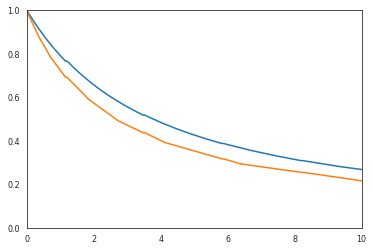

In [87]:
plt.plot(x, (np.array(y2h)/y2h[0]))
plt.plot(x, (np.array(y14d)/y14d[0]))
plt.ylim([0, 1])
plt.xlim([0, 10])

(0.0, 10.0)

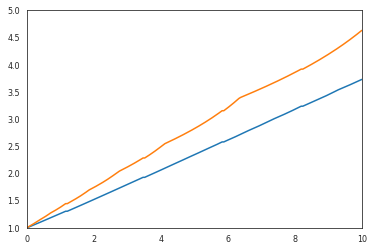

In [88]:
plt.plot(x, 1/(np.array(y2h)/y2h[0]))
plt.plot(x, 1/(np.array(y14d)/y14d[0]))
plt.ylim([1, 5])
plt.xlim([0, 10])

In [22]:
len(alerts[m]

365

In [ ]:
dt.

In [39]:
alerts.columns

Index(['Event', 'Class', 'RA', 'RA Unc (rectangle)', 'Dec',
       'Dec Unc (rectangle)', 'arrival time [UT]', 'Signalness', 'initial RA',
       'initial Dec', 'initial Error90 [arcmin]', 'retracted',
       'direction uncertainty missing', 'reason', 'RA Unc (rectangle) float',
       'Dec Unc (rectangle) float', '2h coverage', '14d coverage', 'observed',
       'area'],
      dtype='object')